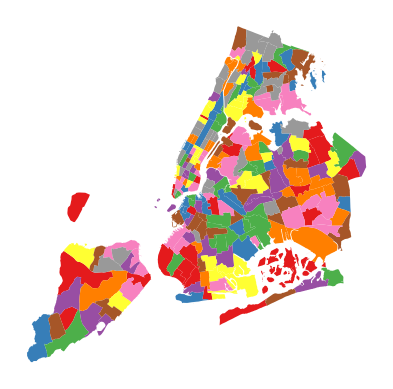

In [147]:
import geopandas as gpd
import matplotlib.pyplot as plt


shapefile = gpd.read_file("../taxi_zones")
shapefile.plot("OBJECTID", cmap="Set1")
plt.axis('off')
# plt.savefig('world.jpg')
plt.show()

# Load data

In [2]:
import pandas as pd
import os

categories = ['fhv', 'green', 'yellow']
years = ['2019', '2020', '2021', '2022', '2023']

def prepare_file_paths(year, category):
    file_names = os.listdir(os.path.join('dataset_nyc_taxi', category, year))
    file_paths = [os.path.join('dataset_nyc_taxi', category, year, file_name) for file_name in file_names]
    return file_paths

test_file_path = 'dataset_nyc_taxi/fhv/2020/fhvhv_tripdata_2020-01.parquet'

df = pd.read_parquet(test_file_path)

# Preprocessing

## Drop outliers

### trip_time[s] -> trip_time[min]; 1 < trip_time < 100

In [3]:
df["trip_time"] = df["trip_time"]/60

<Axes: >

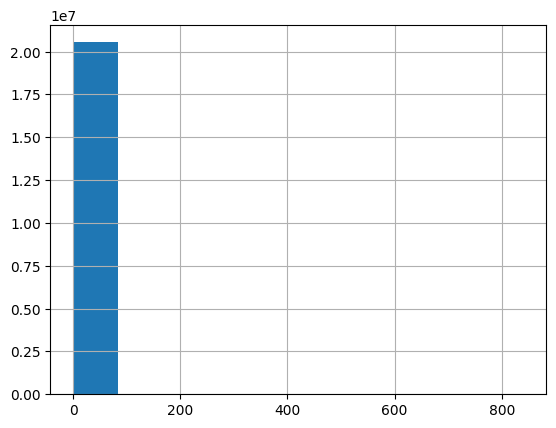

In [4]:
df["trip_time"].hist()

<Axes: >

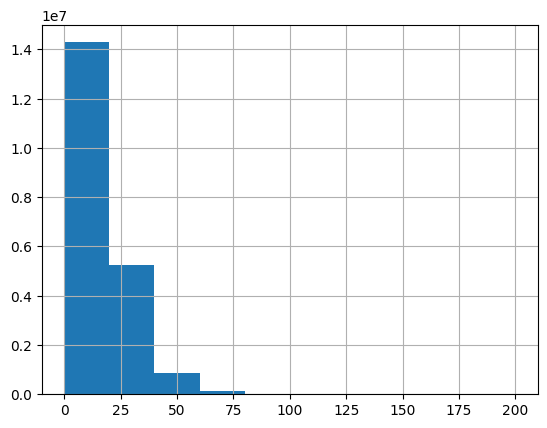

In [5]:
df["trip_time"][df["trip_time"] < 200].hist()

<Axes: >

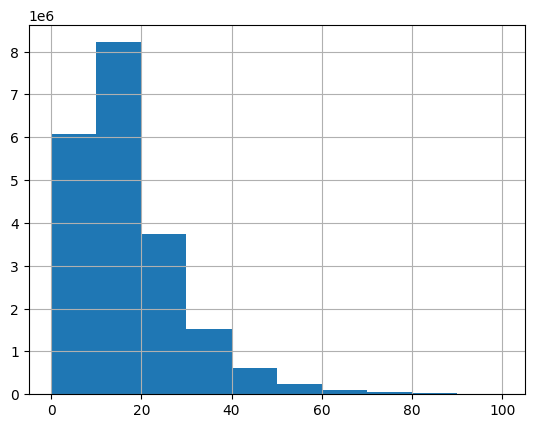

In [6]:
df["trip_time"][df["trip_time"] < 100].hist()

In [7]:
print("Length before:", len(df))
df = df[(df["trip_time"] > 1) & (df["trip_time"] < 100)]
print("Length after:", len(df))

Length before: 20569368
Length after: 20555886


### 0.1 < trip_miles

<Axes: >

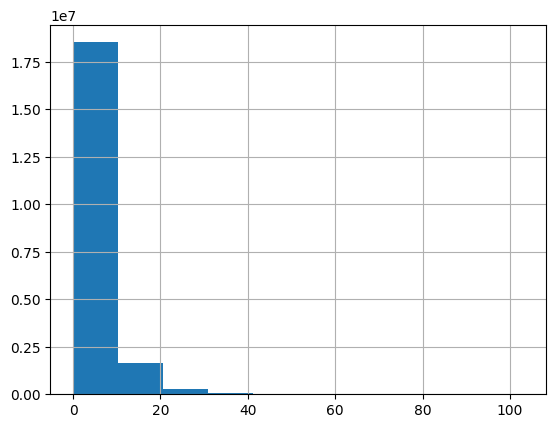

In [8]:
df["trip_miles"].hist()

In [9]:
print("Length before:", len(df))
df = df[(df["trip_miles"] > 0.1) & (df["trip_miles"] < 35)]
print("Length after:", len(df))

Length before: 20555886
Length after: 20359948


### 0.1 < base_passenger_fare < 120

<Axes: >

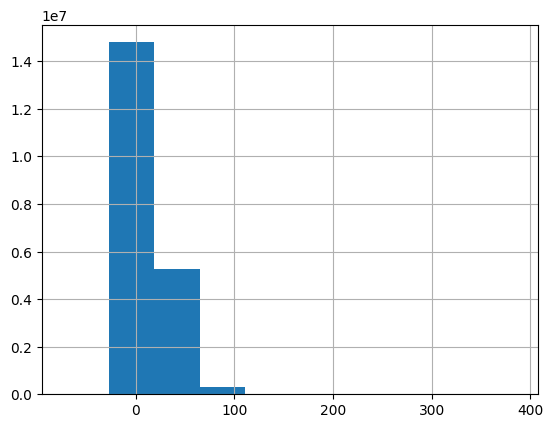

In [10]:
df["base_passenger_fare"].hist()

<Axes: >

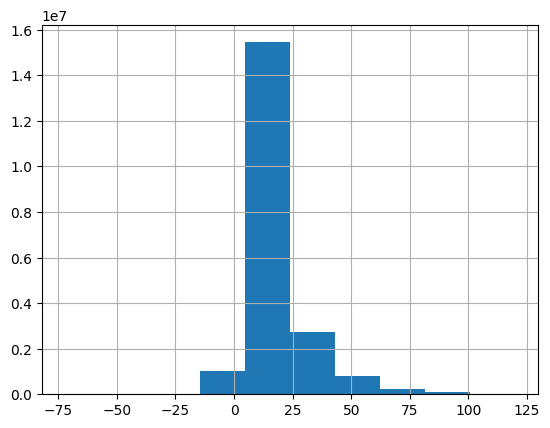

In [11]:
df["base_passenger_fare"][df["base_passenger_fare"] < 120].hist()

In [12]:
min(df["base_passenger_fare"])

-72.35

In [13]:
print("Length before:", len(df))
df = df[(df["base_passenger_fare"] > 0.1) & (df["base_passenger_fare"] < 120)]
print("Length after:", len(df))

Length before: 20359948
Length after: 20308814


In [14]:
df["base_passenger_fare"]

0           30.44
1           14.80
2           15.63
3            8.44
4           11.57
            ...  
20569363    10.20
20569364    18.65
20569365    12.02
20569366    25.59
20569367     7.83
Name: base_passenger_fare, Length: 20308814, dtype: float64

## Update with new columns

In [15]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [16]:
df["base_passenger_fare_per_trip_time"] = df["base_passenger_fare"]/df["trip_time"]

df["base_passenger_fare_per_trip_miles"] = df["base_passenger_fare"]/df["trip_miles"] 

## Combine dataframes

In [17]:
columns_to_compute_mean = ['base_passenger_fare_per_trip_miles', 'base_passenger_fare_per_trip_time']

mean_values_per_id = df.groupby('PULocationID')[columns_to_compute_mean].mean()

In [18]:
shapefile = gpd.read_file("../taxi_zones")


In [19]:
merged_df = pd.merge(shapefile, mean_values_per_id, left_on='OBJECTID', right_on='PULocationID', how='outer')

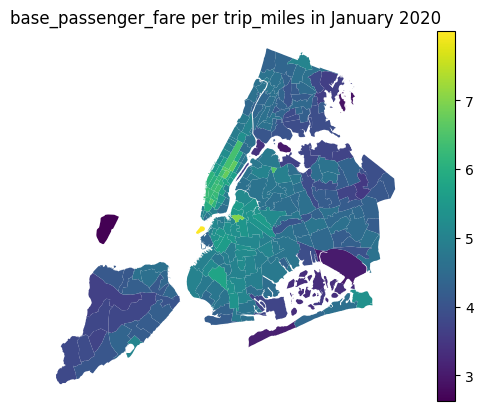

In [20]:
merged_df.plot(column="base_passenger_fare_per_trip_miles", legend=True)
plt.axis('off')
plt.title("base_passenger_fare per trip_miles in January 2020")
plt.show()

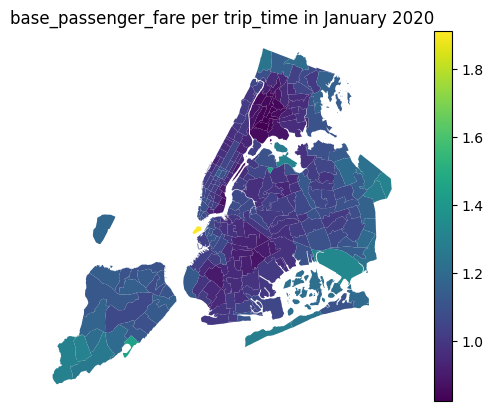

In [21]:
merged_df.plot(column="base_passenger_fare_per_trip_time", legend=True)
plt.axis('off')
plt.title("base_passenger_fare per trip_time in January 2020")
plt.show()

In [22]:
# base_passenger_fare
# tolls
# bcf
# sales_tax
# congestion_surcharge
# airport_fee
# tips
# driver_pay

## Traffic between areas

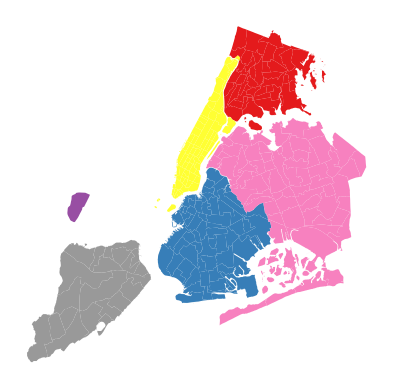

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile = gpd.read_file("../taxi_zones")
shapefile.plot("borough", cmap="Set1")
plt.axis('off')
plt.show()

### Combine zones into polygons

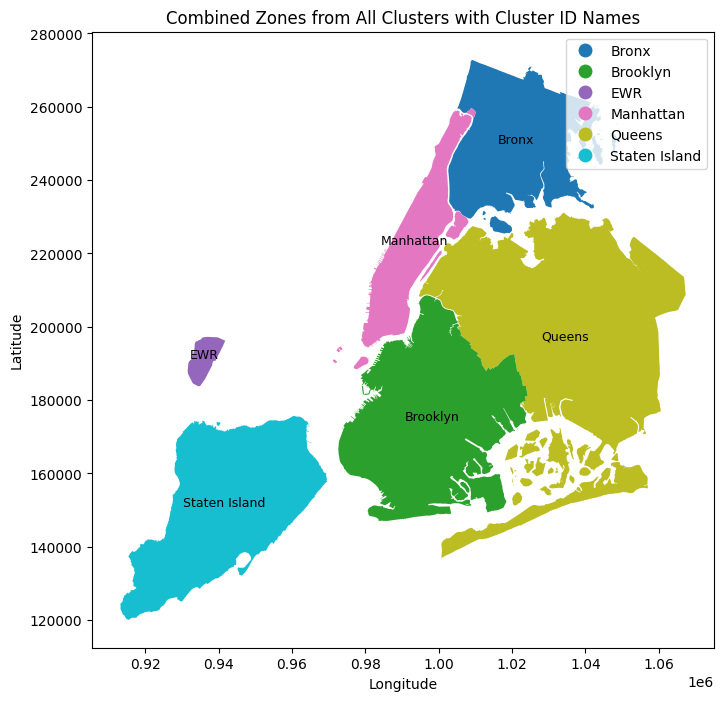

In [81]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named 'zones' with 'cluster_id' column indicating the cluster ID
# Replace 'zones' with your actual GeoDataFrame name

# Define a list to store the combined geometries
combined_zones = []

# Loop through each unique cluster ID
for cluster_id in shapefile['borough'].unique():
    # Filter the GeoDataFrame based on the cluster ID
    cluster_zones = shapefile[shapefile['borough'] == cluster_id]
    # Combine the geometries of the filtered GeoDataFrame
    combined_geometry = cluster_zones.unary_union
    # Append the combined geometry to the list
    combined_zones.append(combined_geometry)

# Create a GeoSeries from the combined geometries
combined_zones_geoseries = gpd.GeoSeries(combined_zones)

# Convert the GeoSeries to a GeoDataFrame
combined_zones_gdf = gpd.GeoDataFrame(geometry=combined_zones_geoseries)

# Add cluster_id to the GeoDataFrame
combined_zones_gdf['ZONE_ID'] = shapefile['borough'].unique()

# Plot the combined zones with cluster ID names
ax = combined_zones_gdf.plot(column='ZONE_ID', legend=True, figsize=(15, 8))

# Add cluster ID names to the plot
for x, y, label in zip(combined_zones_gdf.geometry.centroid.x, combined_zones_gdf.geometry.centroid.y, combined_zones_gdf['ZONE_ID']):
    ax.text(x, y, label, fontsize=9, ha='center')

# Add title and labels
plt.title('Combined Zones from All Clusters with Cluster ID Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


### Aggregate dataframe to compute traffic between zones

In [27]:
location_to_borough_mapping = dict(zip(shapefile['LocationID'], shapefile['borough']))
df["PULocationBorough"] = df.PULocationID.map(location_to_borough_mapping)
df["DOLocationBorough"] = df.DOLocationID.map(location_to_borough_mapping)

In [115]:
# Group by 'PULocationBorough' and 'DOLocationBorough' and count the rows
result = df.groupby(['PULocationBorough', 'DOLocationBorough']).size().reset_index(name='movement_amount')

# Rename columns to match the expected result
result = result.rename(columns={'PULocationBorough': 'origin', 'DOLocationBorough': 'destination'})

# Convert to dictionary
movement_data = result.to_dict(orient='list')

### Plot traffic between zones


/tmp/ipykernel_10241/2356666317.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


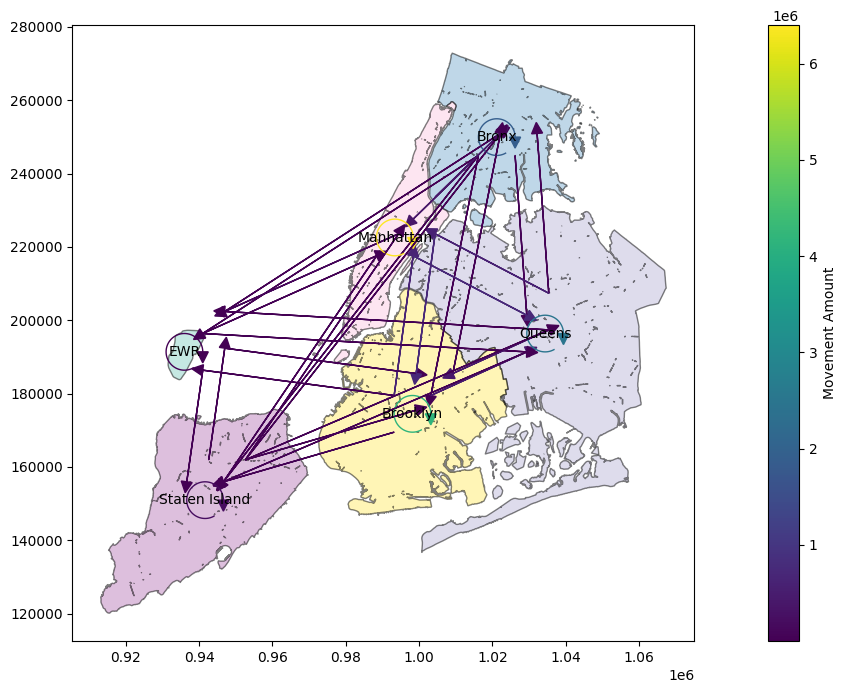

In [138]:
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import numpy as np

zones = combined_zones_gdf

# Convert movement data to a GeoDataFrame
movements = gpd.GeoDataFrame(movement_data)


# Merge movement data with zone geometries to get centroids
movements = movements.merge(zones, left_on='origin', right_on='ZONE_ID', suffixes=('_movement', '_origin'))
movements = movements.merge(zones, left_on='destination', right_on='ZONE_ID', suffixes=('_origin', '_destination'))

# Create LineString geometries for arrows (from origin to destination)
movements['geometry'] = [LineString([origin.centroid.coords[0], destination.centroid.coords[0]]) 
                         for origin, destination in zip(movements['geometry_origin'], movements['geometry_destination'])]

movement_arrows = gpd.GeoDataFrame(movements, geometry='geometry')

# Plot zones
zones.plot(edgecolor='black', alpha=0.5, figsize=(19, 8), cmap="Set3")

# Plot arrows with heatmap based on movement amount
norm = Normalize(vmin=movement_arrows['movement_amount'].min(), vmax=movement_arrows['movement_amount'].max())
cmap = plt.cm.get_cmap('viridis')
mapper = ScalarMappable(norm=norm, cmap=cmap)   

lines = []
for line in movement_arrows['geometry']:
    coords = list(line.coords)
    coords = [list(coords[0]), list(coords[1])]
    
    center_distance = 5000
    if coords[0][0] > coords[1][0]: # x
        coords[0][0] = coords[0][0] - center_distance
        coords[1][0] = coords[1][0] + center_distance
    elif coords[0][0] < coords[1][0]:
        coords[0][0] = coords[0][0] + center_distance
        coords[1][0] = coords[1][0] - center_distance
        
    if coords[0][1] > coords[1][1]: # y
        coords[0][1] = coords[0][1] - center_distance
        coords[1][1] = coords[1][1] + center_distance
    elif coords[0][1] < coords[1][1]:
        coords[0][1] = coords[0][1] + center_distance
        coords[1][1] = coords[1][1] - center_distance
     
    coords_inverted = [coords[1], coords[0]]
    if coords_inverted in lines:
        offset = 6000
        coords = [(coords[0][0] + offset, coords[0][1] + offset), (coords[1][0] + offset, coords[1][1] + offset)]

    lines.append(coords)

for line, amount in zip(lines, movement_arrows['movement_amount']):
    color = mapper.to_rgba(amount)
    lc = LineCollection([line], color=color, linewidth=1)
    plt.gca().add_collection(lc)
    
    # Add arrows
    x0, y0 = line[0]
    x1, y1 = line[1]
    if x0 == x1 and y0 == y1:  # Zone movement to itself
        radius = 5000
        angle = np.linspace(0, 2 * np.pi * 0.83, 100)  # End at 300 degrees
        circle_x = x0 + radius * np.cos(angle)
        circle_y = y0 + radius * np.sin(angle)
        plt.plot(circle_x, circle_y, color=color, linewidth=1)
        
        # Calculate the endpoint of the arrow
        plt.arrow(x0 + radius, y0, 0, -0.01, color=color, head_width=3000, head_length=3000)
    else:
        plt.arrow(x0, y0, x1 - x0, y1 - y0, color=color, head_width=3000, head_length=3000)

# Add names of zones in the center of each zone
for idx, zone in zones.iterrows():
    zone_name = zone['ZONE_ID']  # assuming 'ZONE_ID' contains the zone names
    centroid = zone['geometry'].centroid
    plt.text(centroid.x, centroid.y, zone_name, ha='center', va='center')

# Add colorbar
cbar = plt.colorbar(mapper, ax=plt.gca())
cbar.set_label('Movement Amount')

plt.show()
